Requisitos
- **Python 3.6** (conda create -n tf-gpu python=3.6)
- **CUDA Toolkit 10.0** [https://developer.nvidia.com/cuda-zone](https://developer.nvidia.com/cuda-zone)
- **CUDNN 7.4.1** [https://developer.nvidia.com/cudnn](https://developer.nvidia.com/cudnn)
- **tensorflow-gpu 1.13.1** (pip install tensorflow-gpu==1.13.1)

In [0]:
%load_ext autoreload

In [0]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
from pathlib import Path

# Importamos las libresrías del repo Matterport's "mrcnn" 
 https://github.com/matterport/Mask_RCNN

- Clonamos el Mask_RCNN en nuestra computadora..
- Actualizamos el root del repo.
- Si es necesario usamos pip install.

Leer la documentación

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [6]:
# Es el ROOT donde esta el repositorio clonado
ROOT_DIR = '/content/drive/My Drive/matterport_mask_rcnn'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR no existe ;)'

# Importamos las librerías
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


# Carga de modelos  pre-entrenados 
Default lleva a sub-directorios en nuestro mask_rcnn_dir, si queremos cambiarlos es aquí.

Descarga también modelo de coco preentrenado

In [0]:
# IMPORTANTE AQUÍ EN longs se salvan los modelos y checkpoints
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path local a pesos preentrenados
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Descargamos pesos de COC por si necesitamos
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Configuración
Definimos configuración del entranamiento para box_dataset_synthetic dataset.
- Aupi ajustamos parámetros para nuestro dataset en particular.
- Cambiamos:
    - NAME (nombre de nuestro modelo)
    - NUM_CLASSES (siempre 1 + el número de categorías)
    - IMAGE_MIN_DIM (si tenemos imágenes mas grandes)
    - IMAGE_MAX_DIM (ipara entrenar con imágenes mas grandes)
    - STEPS_PER_EPOCH (tamaño del batch por época)

### Note

In [9]:
class CocoSynthConfig(Config):
  
    # Le damos a la configuración un buen nombre
    NAME = "agua_dataset"

    # Dejálo así a menos que cuentes con más GPUS. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Número de clases, incluypendo el backgroung
    NUM_CLASSES = 1 + 4  # background + categorías

    # Tamaño de nuestras imágenes
    IMAGE_MIN_DIM = 512   
    IMAGE_MAX_DIM = 512

    # Podemos experimentar para ver si mejora el entrenamiento...algo así como el batch
    STEPS_PER_EPOCH = 1000 

    # Cada cuanto corre la validación. Si se usa muchos recursos
    # en modelos salvados (in the MODEL_DIR), hay que hacerlo mas grande
    VALIDATION_STEPS = 10
    
    # Cambiar a conveniencia
    BACKBONE = 'resnet50'

    # Hay que dejarlos así; configuraciones del GPU
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CocoSynthConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

# Definimos el dataset
Se hace igual que el dataset genérico de COCO

In [0]:
class CocoLikeDataset(utils.Dataset):
    """ Generates una imagen etiquetada al estilo del COCO dataset.
    """
    def load_data(self, annotation_json, images_dir):
        
        # Carga del json
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
       
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Anotaciones
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Obtenemos todas las imágenes y las añadimos al dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Añadimos la imagen utilizando el visualize del dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Cargamos la imagen delas mascaras.
        MaskRCNN espoera máscaras en forma de bitmaps [height, width, instances].
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Training y Validation Datasets
Cuidado con los paths

In [0]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/drive/My Drive/training/coco_instances.json',
                        '/content/drive/My Drive/training/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/drive/My Drive/validation/coco_instances.json',
                      '/content/drive/My Drive/validation/images')
dataset_val.prepare()

## Muestra de algunas imágenes de los conjuntos de val y train
Para ver si todo anda bien

Displaying examples from training dataset:


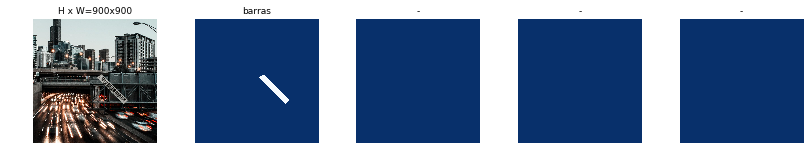

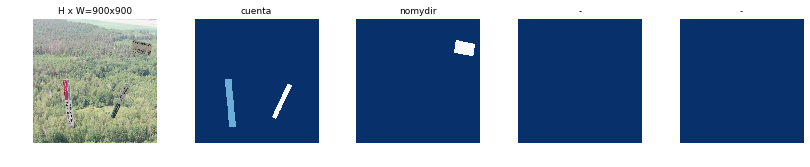

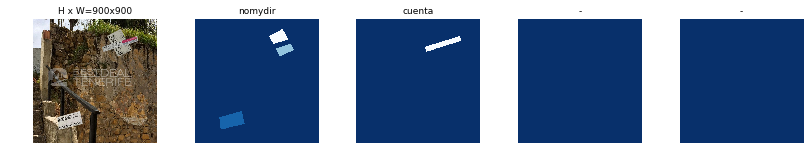

Displaying examples from validation dataset:


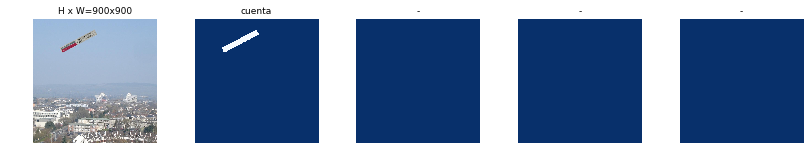

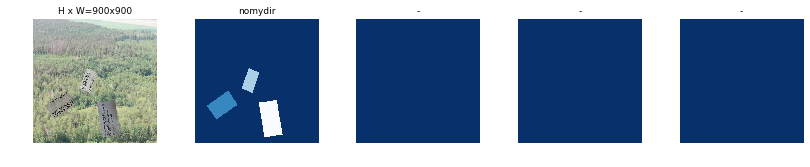

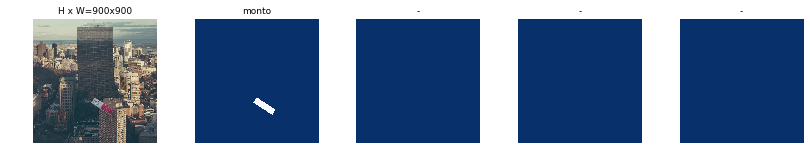

In [13]:
for name, dataset in [('training', dataset_train), ('validation', dataset_val)]:
    print(f'Displaying examples from {name} dataset:')
    
    image_ids = np.random.choice(dataset.image_ids, 3)
    for image_id in image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Creamos modelo y entrenamos
El código es el de el Matterport repo.

In [14]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

W0717 22:17:26.857265 140447228376960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 22:17:26.911276 140447228376960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 22:17:26.939783 140447228376960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 22:17:26.980352 140447228376960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0717 22:17:26.985970 140447228

In [0]:
# Definimos con que pesos iniciamos
init_with = "coco"  # imagenet, coco, or último

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Carga pesos que se entrenaron con MS COCO, pero salta capas que son diferentes debido al número de clases
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Cargamos último modelo entrenado y continuamos
    model.load_weights(model.find_last(), by_name=True)

## Training
2 etapas:

1. Transfer learning o solo heads. Aquí hacemos freeze de las capas anteriores: solo se pasa heads a la func.

2.todas las capas: poner all a la función

In [16]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/matterport_mask_rcnn/logs/agua_dataset20190717T2218/mask_rcnn_agua_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4

W0717 22:20:42.262223 140447228376960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Co

Epoch 1/4


Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/content/drive/My Drive/matterport_mask_rcnn/mrcnn/model.py", line 1719, in data_generator
    gt_class_ids, gt_boxes, config)
  File "/content/drive/My Drive/matterport_mask_rcnn/mrcnn/model.py", line 1518, in build_rpn_targets
    ids = np.random.choice(ids, extra, replace=False)
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (

  File "/content/drive/My Drive/matterport_mask_rcnn/mrcnn/utils.py", line 903, in resize
    anti_aliasing_sigma=anti_aliasing_sigma)
  File "/content/drive/My Drive/matterport_mask_rcnn/mrcnn/utils.py", line 903, in resize
    anti_aliasing_sigma=anti_aliasing_sigma)
  File "/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py", line 179, in resize
    preserve_range=preserve_range)
  File "/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py", line 871, in warp
    order=order, mode=mode, cval=cval))
  File "/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py", line 179, in resize
    preserve_range=preserve_range)
  File "skimage/transform/_warps_cy.pyx", line 174, in skimage.transform._warps_cy._warp_fast
  File "/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py", line 871, in warp
    order=order, mode=mode, cval=cval))
  File "/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py", line 469, in asarray
    @set_m

KeyboardInterrupt: ignored

In [20]:
# TODAS LAS CAPAS
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=7, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 4. LR=0.0001

Checkpoint Path: /content/drive/My Drive/matterport_mask_rcnn/logs/agua_dataset20190717T0440/mask_rcnn_agua_dataset_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 5/7
1000/1000 [==============================] - 568s 568ms/step - loss: 0.6080 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.3075 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.1019 - val_loss: 3.6240 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.5735 - val_mrcnn_class_loss: 2.5388 - val_mrcnn_bbox_loss: 0.2921 - val_mrcnn_mask_loss: 0.2110
Epoch 6/7
1000/1000 [==============================] - 531s 531ms/step - loss: 0.5522 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.2856 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1011 - val_loss: 4.5021 - val_rpn_class_loss: 0.0403 - val_rpn_bbox_loss: 0.8849 - val_mrcnn_class_loss: 2.4126 - val_mrcnn_bbox_loss: 0.3986 - val_mrcnn_mask_loss: 0.7657
Epoch 7/7
1000/1000 [==============================] - 531s 531ms/step - loss: 0.4544 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.0971 - val_loss: 2.3716 - val

# Preparamos para la Inferencia
Creamos InferenceConfig, y usamos para crear un nuevo modelo.

In [0]:
class InferenceConfig(CocoSynthConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [22]:
# Recreamos el modelo en un modo inferencia
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

W0717 05:34:29.941076 140132019468160 deprecation_wrapper.py:119] From /content/drive/My Drive/matterport_mask_rcnn/mrcnn/model.py:720: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0717 05:34:30.073149 140132019468160 deprecation.py:323] From /content/drive/My Drive/matterport_mask_rcnn/mrcnn/model.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


### cargamos pesos entrenados
Note: set to find_last() por default encuentra el último, pero si queremos otro path hay que cambiarlo acá

In [23]:
# path a pesos salvados
# model_path = str(Path(ROOT_DIR) / "logs" / "box_synthetic20190328T2255/mask_rcnn_box_synthetic_0016.h5" )
model_path = model.find_last()

assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/matterport_mask_rcnn/logs/agua_dataset20190717T0440/mask_rcnn_agua_dataset_0007.h5
Re-starting from epoch 7


# Inferencia
USAR model.detect() EN IMÁGENES REALES.

Usamos "figsize" para cambiar tamaño de la imagen

In [24]:
import skimage

real_test_dir = '/content/drive/My Drive/test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], figsize=(8,8))

Output hidden; open in https://colab.research.google.com to view.

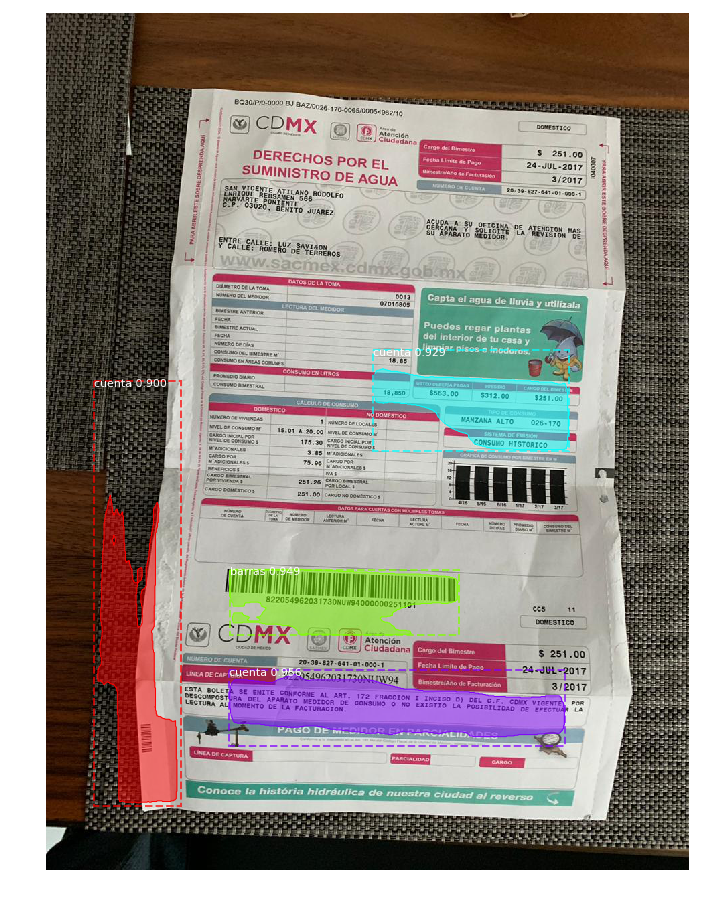

In [152]:
import skimage

path = '/content/drive/My Drive/test/agua1.jpeg'
image = skimage.io.imread(path)

# Corremos detección en una solo imagen
results = model.detect([image], verbose=0)

# Visualizamos
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'])

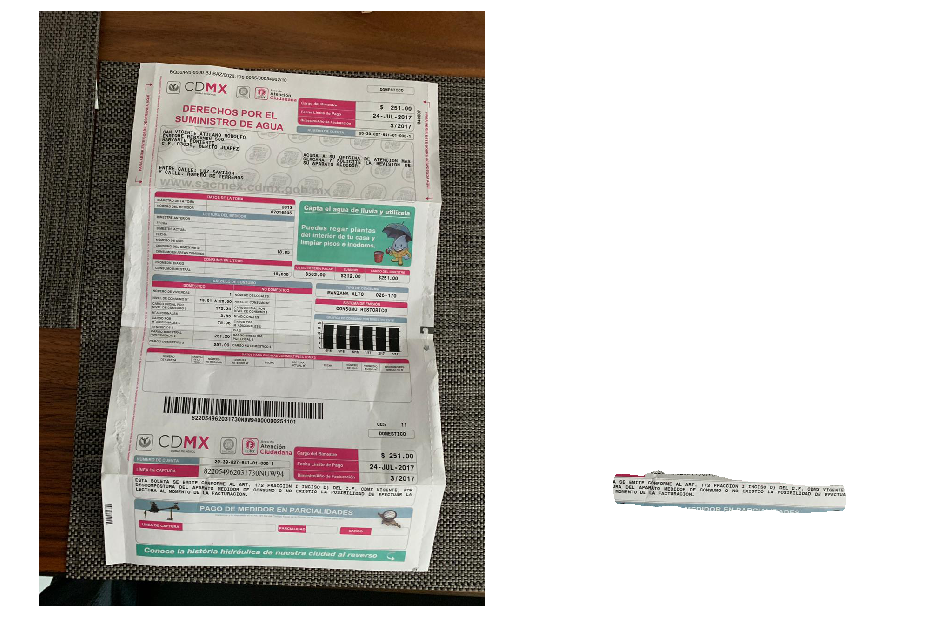

In [35]:
#por si se quiere comparar
segmentation = segment(image, r)
plt.subplots(1, figsize=(16, 16))
plt.axis('off')
plt.imshow(np.concatenate([image, segmentation], axis = 1))

In [6]:
## Bitmap para guardar

In [0]:
#No recuerdo si las puse 
from PIL import Image
import numpy as np

ary = np.array(resultado)

# Separamos los tres canales
r,g,b = np.split(ary,3,axis=2)
r=r.reshape(-1)
g=r.reshape(-1)
b=r.reshape(-1)

# RGB normal a escala de grises 
bitmap = list(map(lambda x: 0.299*x[0]+0.587*x[1]+0.114*x[2], 
zip(r,g,b)))
bitmap = np.array(bitmap).reshape([ary.shape[0], ary.shape[1]])
bitmap = np.dot((bitmap > 128).astype(float),255)
imagen = Image.fromarray(bitmap.astype(np.uint8))
imagen.save('resultado.bmp')